In [15]:
import numpy as np
import pickle
from tensorflow.keras.utils import to_categorical

path = ''

with open(path+"txt_data", "rb") as fp:
    data = pickle.load(fp)
with open(path+"txt_labels", "rb") as fp:   
    labels = pickle.load(fp)

labels = to_categorical(labels)

print(len(data), len(labels))

31702 31702


In [16]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(data,labels, test_size = 0.30, shuffle=True, random_state = 42)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10, shuffle=True, random_state = 33)

print('split done.')

split done.


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer(max_features=500, use_idf=True, stop_words='english')
#vectorizer.fit(data)
#x_train = vectorizer.transform(x_train).toarray()
#x_test = vectorizer.transform(x_test).toarray()
#x_valid = vectorizer.transform(x_valid).toarray()
#print('> tfidVectorization done.')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)

x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

x_valid = tokenizer.texts_to_sequences(x_valid)
x_valid = pad_sequences(x_valid, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', x_train.shape, y_train.shape)

Found 132837 unique tokens.
Shape of data tensor: (19971, 500) (19971, 9)


In [5]:
#x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
#x_valid = x_valid.reshape(x_valid.shape[0], 1, x_valid.shape[1])

x_train = np.array(x_train)#[:,:,None]
x_valid = np.array(x_valid)#[:,:,None]
x_test = np.array(x_test)#[:,:,None]

print('training set',x_train.shape)
print('testing set', x_test.shape)
print('validation set', x_valid.shape)

training set (19971, 500)
testing set (9511, 500)
validation set (2220, 500)


- Long Short-Term Memory 

In [22]:
import keras
from keras import Sequential, Input, Model
from keras.layers import LSTM, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, SpatialDropout1D
import matplotlib.pyplot as plt

In [32]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=x_train.shape[1]))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

#history = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid), verbose=1, batch_size=64)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 500, 100)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 909       
Total params: 5,081,309
Trainable params: 5,081,309
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19971 samples, validate on 2220 samples
Epoch 1/5
19971/19971 [==============================] - 462s 23ms/step - loss: 1.4308 - accuracy: 0.4421 - val_loss: 0.9546 - val_accuracy: 0.6423
Epoch 2/5
19971/19971 [==============================] - 474s 24ms/step - loss: 0.8214 - accuracy: 0.6938 - val_loss: 0.7232 - val_accuracy: 0.7171
Epoch 3/5
19971/19971 [==============================] - 467s 23ms/step - loss: 0.5785 - accuracy: 0.7944 - val_loss: 0.6568 - val_accuracy: 0.7545
Epoch 4/5
19971/19971 [==============================] - 455s 23ms/step - loss: 0.4746 - accuracy: 0.8389 - val_loss: 0.6432 - val_accuracy: 0.7689
Epoch 5/5
19971/19971 [==============================] - 468s 23ms/step - loss: 0.3571 - accuracy: 0.8792 - val_loss: 0.6591 - val_accuracy: 0.7649


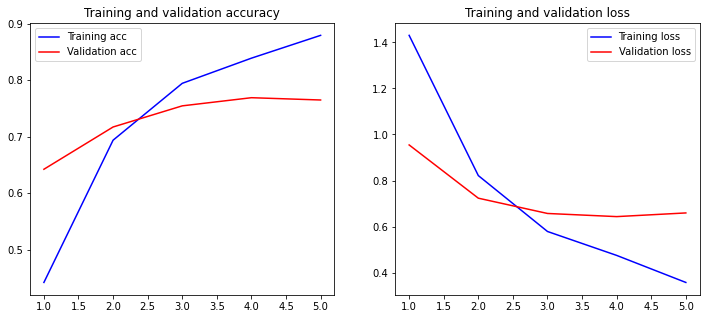

In [33]:

history = model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid), verbose=1, batch_size=64)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, acc, 'b', label='Training acc')
plt.plot(x, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x, loss, 'b', label='Training loss')
plt.plot(x, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

y_pred = model.predict(x_test)


y_pred_cp = np.argmax( y_pred, axis=1)
y_test_cp = np.argmax( y_test, axis=1)
print()
dt = pd.DataFrame(confusion_matrix(y_test_cp, y_pred_cp))
display(dt)
print(classification_report(y_test_cp, y_pred_cp, zero_division=0))

,0,1,2,3,4,5,6,7,8
0,882,21,45,55,30,2,3,16,6
1,5,1097,44,32,34,4,7,6,6
2,19,46,279,33,46,1,1,3,2
3,19,15,27,290,26,10,5,8,8
4,16,47,61,34,950,20,5,13,7
5,7,2,8,23,27,374,3,7,2
6,1,1,0,1,4,0,1190,77,127
7,1,4,1,4,1,1,121,952,642
8,4,5,0,1,6,0,180,274,1174


              precision    recall  f1-score   support

           0       0.92      0.83      0.88      1060
           1       0.89      0.89      0.89      1235
           2       0.60      0.65      0.62       430
           3       0.61      0.71      0.66       408
           4       0.85      0.82      0.83      1153
           5       0.91      0.83      0.86       453
           6       0.79      0.85      0.82      1401
           7       0.70      0.55      0.62      1727
           8       0.59      0.71      0.65      1644

    accuracy                           0.76      9511
   macro avg       0.76      0.76      0.76      9511
weighted avg       0.76      0.76      0.76      9511

